In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

sns.set(style='ticks', palette='bright')
%matplotlib inline

## Generate mean reverting time series with O-U process

$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$

In [2]:
theta, mu, sigma = 0.01, 1, 0.3

T = 10*250*24 # 10yrs * 250days * 24hrs
dt = 1
N = int(T/dt) # Time steps for Euler-Maruyama iteration.
ts = np.arange(0, T, dt)

X = np.empty(N)
X[0] = 1

In [3]:
def dW(delta_t): 
    '''Sample random number for dW_t'''
    return np.random.normal(loc=0, scale=np.sqrt(1/(250*24)))

for i in range(len(ts)-1):
    t = i*dt
    X[i+1] = X[i] + theta*(mu - X[i])*dt + sigma*dW(dt) # Euler-Maruyama iteration.

(array([    0,     1,     2, ..., 59997, 59998, 59999]),
 array([1.        , 1.00263772, 1.0027075 , ..., 1.01593171, 1.01883421,
        1.01826833]))

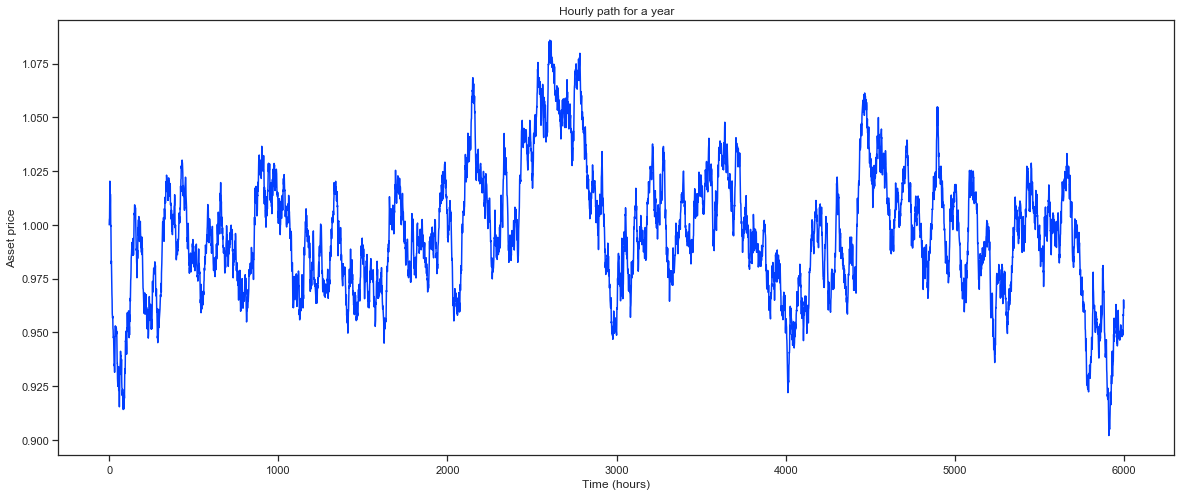

In [4]:
plt.figure(figsize=(20,8))
plt.plot(ts[:250*24], X[:250*24])
plt.xlabel('Time (hours)')
plt.ylabel('Asset price')
plt.title('Hourly path for a year')
ts, X

In [5]:
import pickle

with open('data.pickle', 'wb') as file:
    pickle.dump(X, file)

In [6]:
# with open('data.pickle', 'rb') as handle:
#     Y = pickle.load(handle)

# plt.figure(figsize=(20,8))
# plt.plot(ts[:250*24], Y[:250*24])
# plt.title('Hourly tick for a year')
# None

Note: the above model is simply used to generate meaningful dataset for our problem, preferably with mean reverting property.

# Our problem
Mean reverting asset time series $X_t$, triggering signal $\delta$, time related period $M, N$, and performance measurement to determine parameters.

## *Test if the series is mean reverting and worth further research

In [7]:
import statsmodels.tsa.stattools

statsmodels.tsa.stattools.adfuller(X[:250*24])

(-5.661436251417054,
 9.360173776344851e-07,
 8,
 5991,
 {'1%': -3.4314419886634244,
  '5%': -2.8620225584781047,
  '10%': -2.5670268634401556},
 -49175.02038043105)

Above is a simple Augmented Dickey-Fuller unit root test. The p-value is very small. Our series $X$ is indeed mean reverting. Obviously in this case the process is generated by a classical mean reverting model the O-U process. In reality, we need to test if the series doesn't process random walk. Otherwise, it's impossible to predict.

There are multiple ways to discover the stationary, trending or mean reverting property of time series, including unit root test such as Dickey-Fuller and Hurst exponent.

Here we assume that $X_t$ is worth trading.

## Triggering deviation (The limit crossed)

This section discover the limit $\delta$ which we would consider the observation. If $\delta = 0.000001$, the asset seems pretty stationary. However if $\delta$ is relatively large, which means $X_t$ largely deviates from the mean, we know something happened in the market.

Here we introduce a very simple anomaly detection model using Gaussian distribution. [Anomaly Detection from Machine Learning Course by Andrew Ng](https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-anomaly-detection-1233d23dba95).

(1.000284367036331, 0.02952774771197861)

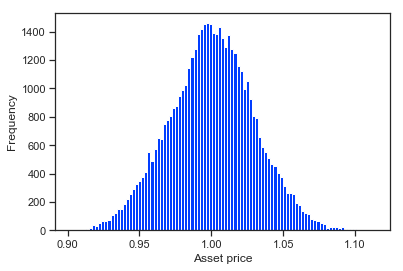

In [8]:
X_train = X[:250*24*8]  # 8 out of 10 years.
plt.hist(X_train, bins='auto')
plt.xlabel('Asset price')
plt.ylabel('Frequency')
mu_MLE, sigma_MLE = stats.norm.fit(X_train)
mu_MLE, sigma_MLE

In [9]:
delta = 0.1
for x in [0.92, 0.95, 0.98, 1, 1.02, 1.05, 1.08]:
    p = stats.norm.cdf(x, mu_MLE, sigma_MLE)
    if p < delta or p > 1 - delta:
        print('Asset is at %f'%x, ', anormaly deviation detected.')

Asset is at 0.920000 , anormaly deviation detected.
Asset is at 0.950000 , anormaly deviation detected.
Asset is at 1.050000 , anormaly deviation detected.
Asset is at 1.080000 , anormaly deviation detected.


In this simple Gaussion abnormal detection model, the threshold level dictates our triggering signal. Given a probability, we can calculate the inverse of cumulative density function as the asset limit trigger.

In [10]:
level = [0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
inv = stats.norm.ppf(level, mu_MLE, sigma_MLE)
for i, l in enumerate(level):
     print('There is %f probability that asset return is less than %f.' % (l, inv[i]))

There is 0.000000 probability that asset return is less than -inf.
There is 0.010000 probability that asset return is less than 0.931593.
There is 0.050000 probability that asset return is less than 0.951716.
There is 0.100000 probability that asset return is less than 0.962443.
There is 0.300000 probability that asset return is less than 0.984800.
There is 0.500000 probability that asset return is less than 1.000284.
There is 0.700000 probability that asset return is less than 1.015769.
There is 0.900000 probability that asset return is less than 1.038126.
There is 0.950000 probability that asset return is less than 1.048853.
There is 0.990000 probability that asset return is less than 1.068976.
There is 1.000000 probability that asset return is less than inf.


In our model, after trained with data and getting the parameters of Gaussian distribution, the level (movement limit trigger) can be seen as a hyperparameter, which we would like to carefully choose, for instance, from grid search technique.

This Gaussian model is decent for our generated data set. In real market, the time series of finanical assets are more complicated. We can try many machine learning models, such as [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) or [Artificial Neural Network](https://en.wikipedia.org/wiki/Artificial_neural_network). Once we get the decision boundary of "normal" or "abnormal deviation", we are good.

Overall, determination to movement limit $\delta$ using statistical learning is simply an advanced pipeline methodology to train our proprietary signal like bollinger bands. The hyperparameter to be grid-searched can be the parameters of bollinger band, levels of Gaussian model, or those in more advanced SVM algorithm.

## Triggering exit (Return to "normal" level)

It comes naturally that a decent exit signal can be a return-to-normal crossing to the decision boundary based on the model we trained above. Moreover, we have another parameter to consider, the time period, as follows:

## Time to mean revert (M and N period in our problem)

Here we introduce a concept for mean reverting time series called [half-life](https://en.wikipedia.org/wiki/Half-life), originated from nuclear physics. This concept is highly relevant to the classic O-U stochastic process above. The Half-life of an O-U process is $\frac{\ln(2)}{\theta}$. But given a time series, how to we estimate the mean reverting speed "$\theta$"? 

A simple way is to model the series linearly, like $\Delta X_t = -\theta X_{t-1} \Delta t$. Note $\Delta t$ here is 1-hour. If we use a different granularity, say 24 hours, the estimated half-life $hl$ will depend on the 24 hours lag. This is another hyperparamter for our overall pipeline, which may deserve to grid search.

In [11]:
granularity = 1
m = len(X_train) - 2
xx = X_train[1:-1].reshape((m, 1)) 
yy = (np.roll(X_train, -granularity)[1:-1] - X_train[1:-1]).reshape((m, 1)) 

In [12]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(xx, yy)

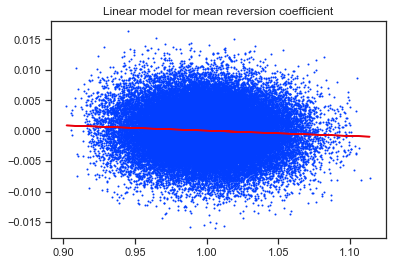

In [13]:
plt.plot (xx, reg.intercept_+reg.coef_*xx, c='r')
plt.scatter(xx, yy, s=1)
plt.title('Linear model for mean reversion coefficient')
None

The slope is negative. The series tends to mean revert.

In [14]:
hl = np.asscalar(- np.log(2) / reg.coef_)
print('Half life of the time series is %f' % hl, '* %f hours' %dt)

Half life of the time series is 79.652593 * 1.000000 hours


The above half life provides a good guidance about how long the series pull back half to the mean. Our hyperparameter can be set as multiples of the $hl$. For example, we grid search $(M, \Delta t)$ where $M = [a_1*hl, a_2*hl, ..., a_j*hl]$ depending on $\Delta t= 1, 2, 12, 24, ...$ 

## Model metrics and grid search structure

For simplicity we only use data of first 6000 hours.

### A specific case
Entry signal detected by Gaussian, with one side event probablity level $p=0.05$. Exit takes half life into consideration. Granularity is 1 hour.

In [87]:
p1, p2 = 0.05, 0.3
entry = (stats.norm.ppf(p1, mu_MLE, sigma_MLE), stats.norm.ppf(1 - p1, mu_MLE, sigma_MLE))
exit = (stats.norm.ppf(p2, mu_MLE, sigma_MLE), stats.norm.ppf(1 - p2, mu_MLE, sigma_MLE))
entry, exit

((0.951715544116575, 1.0488531899560871),
 (0.9848000009970558, 1.0157687330756062))

In [88]:
trades = np.empty((0,3)) # [entry, exit, long or short]

In [101]:
for t, x in enumerate(X_train):
    # No trades so far or last trade finished. Entry mode.
    if len(trades) == 0 or trades[-1, 1] is not None:
        if x < entry[0]: # Entry signal for long
            trades = np.append(trades, [[x, None, 1]], axis=0)
        if x > entry[1]: # Entry signal for short
            trades = np.append(trades, [[x, None, -1]], axis=0)

    # Had a trade so far. Exit mode.
    if len(trades) > 0 and trades[-1, 1] is None:
        if trades[-1, 2] == 1 and x > exit[0]: # Exit signal for long
            trades[-1, 1] = x
        if trades[-1, 2] == -1 and x < exit[1]: # Exit signal for short
            trades[-1, 1] = x

In [106]:
profit = (trades[:-1, 1] - trades[:-1, 0]) * trades[:-1, 2]
sum(profit)

5.17349184186479

In [15]:
# class MeanReversion()

#     def __init__(self, X, p, dt)
#         self.X = X
    
#     def adfuller(self, i):
#         return statsmodels.tsa.stattools.adfuller(self.X[:250*24])


## Summary

1. Mean reversion test.

Rigorously we can test if a given series has mean reversion property. It's insightful, even if the time series doesn't yield obvious trending or contrarian property. If tests such as augmented dickey-fuller or Hurst exponent don't show significance, there can be opportunity for us to trade.

2. Entry and exit trigger (X: the limit crossed)

This can be done as simply as Bollinger signal, or as advanced as neural network, support vector machine or random forest. In our notebook, we use elegant Gaussian model to get decision boundary (entry and exit) from probability level. These are hyperparameters that we can grid search. $[0.01, 0.05, 0.1, 0.15, 0.2]$ and $[0.3, 0.4, 0.5]$